In [1]:
import numpy as np
import nibabel as nib
import os
import glob
import pandas as pd
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt

/gpfs/share/apps/python/gpu/3.6.5/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


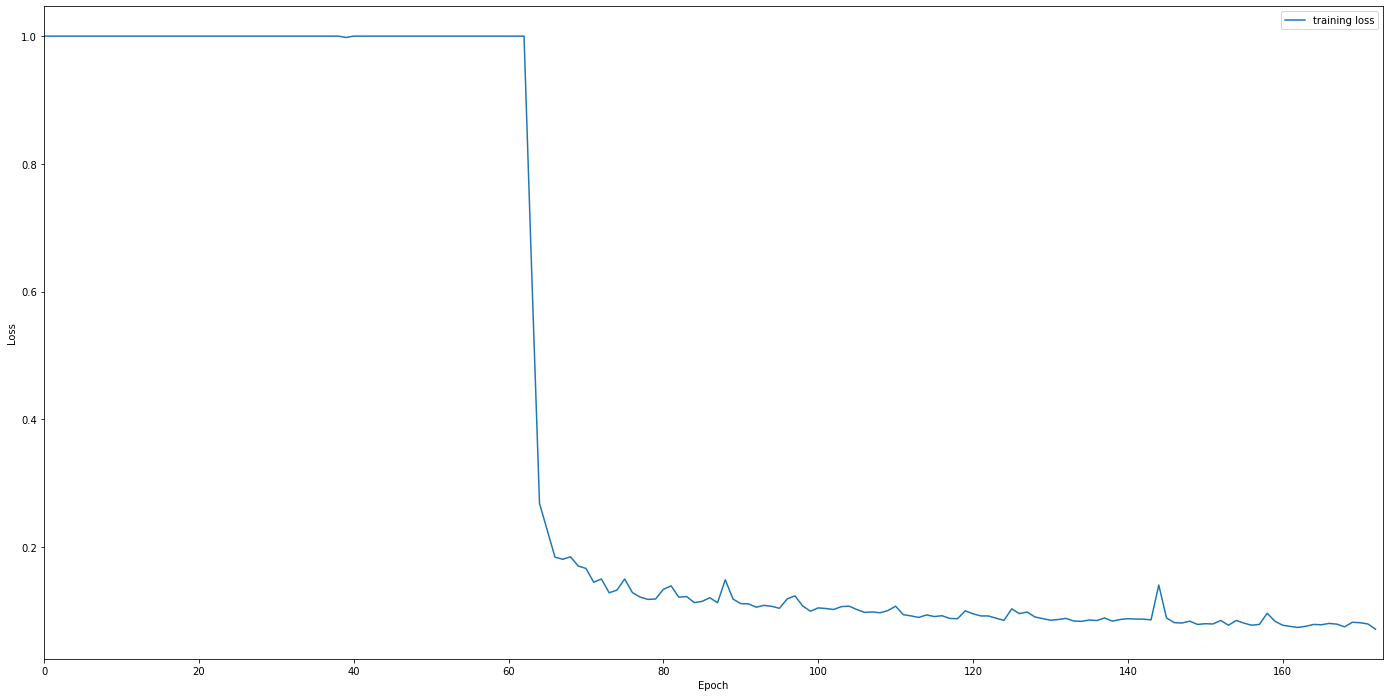

In [25]:
if os.path.exists("./VS_baseline_training_log.csv"):
    training_df = pd.read_csv("./VS_baseline_training_log.csv").set_index('epoch')

    plt.plot(training_df['loss'].values, label='training loss')
#     plt.plot(training_df['val_loss'].values, label='validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim((0, len(training_df.index)))
    plt.legend(loc='upper right')
    #plt.savefig('loss_graph.png')

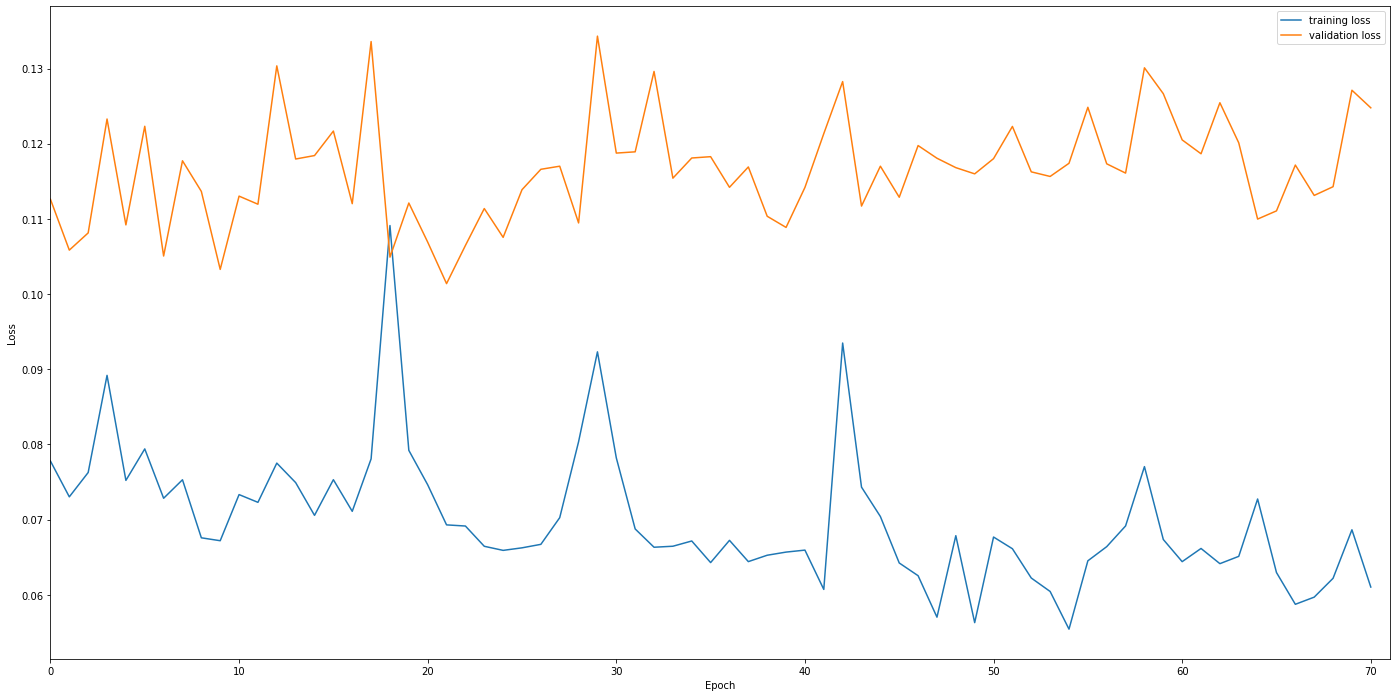

In [29]:
if os.path.exists("./VS_baseline_training_log.csv"):
    training_df = pd.read_csv("./VS_baseline_trainingval_log.csv").set_index('epoch')

    plt.plot(training_df['loss'].values, label='training loss')
    plt.plot(training_df['val_loss'].values, label='validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim((0, len(training_df.index)))
    plt.legend(loc='upper right')
    #plt.savefig('loss_graph.png')

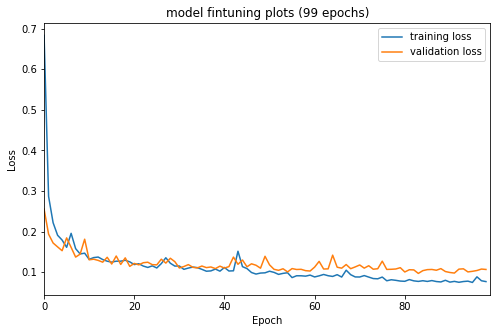

In [26]:
plt.rcParams['figure.figsize']=8,5
if os.path.exists("./VS_pretrain_trainingval_log.csv"):
    training_df = pd.read_csv("./VS_pretrain_trainingval_log.csv").set_index('epoch')
    training_df = training_df.drop(96)
    plt.plot(training_df['loss'].values, label='training loss')
    plt.plot(training_df['val_loss'].values, label='validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim((0, len(training_df.index)))
    plt.legend(loc='upper right')
    plt.title('model fintuning plots (99 epochs)')
    #plt.savefig('loss_graph.png')

In [31]:
training_df.drop(96)

,loss,lr,val_loss
epoch,,,
0,0.683597,0.00010,0.255542
1,0.286816,0.00010,0.193699
2,0.221946,0.00010,0.171914
3,0.190927,0.00010,0.162263
4,0.179136,0.00010,0.152888
...,...,...,...
94,0.077868,0.00005,0.100657
95,0.074679,0.00005,0.102113
97,0.088487,0.00005,0.104094


In [30]:
training_df

,loss,lr,val_loss
epoch,,,
0,0.683597,0.00010,0.255542
1,0.286816,0.00010,0.193699
2,0.221946,0.00010,0.171914
3,0.190927,0.00010,0.162263
4,0.179136,0.00010,0.152888
...,...,...,...
95,0.074679,0.00005,0.102113
96,0.074917,0.00005,0.487242
97,0.088487,0.00005,0.104094


In [1]:
import sys
sys.path.append('/gpfs/data/yuanlab/projects/VS_Proj20/env_cc7027/lib/python3.6/site-packages')

In [2]:
import torch
import torchvision
import torchio as tio
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

/gpfs/share/apps/python/gpu/3.6.5/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
plt.rcParams['figure.figsize']=25,15

In [4]:
def dice_score(y_pred, y_true):
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    assert y_pred.shape == y_true.shape
    return (np.sum(y_pred[y_true == 1]) * 2.0) / (np.sum(y_pred) + np.sum(y_true))

## without pretrained

In [6]:
#best model 130 epochs used training dataset only
test_result = []
for pred_path in Path('./predictions_130_epochs').iterdir():
    patient = 'VS' + str(pred_path).split('_')[-1].split('.')[0]
    ground_truth_path = './data/'+patient

    try:
        VSpt=tio.Subject(
            mri=tio.LabelMap(sorted(Path(ground_truth_path).glob('*image*'))[0]),
            VSmask_truth=tio.LabelMap(sorted(Path(ground_truth_path).glob('*mask_VS*'))[0]),
            VSmask_pred=tio.LabelMap(Path(pred_path)),
        )
    except:
        print(patient)
        continue

    y_pred = VSpt.VSmask_pred['data'][0,:,:,:]
    y_true = VSpt.VSmask_truth['data'][0,:,:,:]/255
        
    unit_size = np.prod(VSpt.VSmask_truth.spacing)
    vol = (y_true.sum()*unit_size).cpu().detach().numpy() ##unit: mm^3
    
    
    score = dice_score(y_pred, y_true)
    test_result.append([patient,score,vol])


In [11]:
#used best model on val to test on test_data
test_result = []
for pred_path in Path('./predictions_test_130_epochs').iterdir():
    patient = 'VS' + str(pred_path).split('_')[-1].split('.')[0]
    ground_truth_path = './data/'+patient

    try:
        VSpt=tio.Subject(
            mri=tio.LabelMap(sorted(Path(ground_truth_path).glob('*image*'))[0]),
            VSmask_truth=tio.LabelMap(sorted(Path(ground_truth_path).glob('*mask_VS*'))[0]),
            VSmask_pred=tio.LabelMap(Path(pred_path)),
        )
    except:
        print(patient)
        continue

    y_pred = VSpt.VSmask_pred['data'][0,:,:,:]
    y_true = VSpt.VSmask_truth['data'][0,:,:,:]/255
        
    unit_size = np.prod(VSpt.VSmask_truth.spacing)
    vol = (y_true.sum()*unit_size).cpu().detach().numpy() ##unit: mm^3
    
    
    score = dice_score(y_pred, y_true)
    test_result.append([patient,score,vol])

## With pretrain model

In [5]:
#used last model on train_val 
test_result = []
for pred_path in Path('./predictions_test_99_epochs').iterdir():
    patient = 'VS' + str(pred_path).split('_')[-1].split('.')[0]
    ground_truth_path = './data/'+patient

    try:
        VSpt=tio.Subject(
            mri=tio.LabelMap(sorted(Path(ground_truth_path).glob('*image*'))[0]),
            VSmask_truth=tio.LabelMap(sorted(Path(ground_truth_path).glob('*mask_VS*'))[0]),
            VSmask_pred=tio.LabelMap(Path(pred_path)),
        )
    except:
        print(patient)
        continue

    y_pred = VSpt.VSmask_pred['data'][0,:,:,:]
    y_true = VSpt.VSmask_truth['data'][0,:,:,:]/255
        
    unit_size = np.prod(VSpt.VSmask_truth.spacing)
    vol = (y_true.sum()*unit_size).cpu().detach().numpy() ##unit: mm^3
    
    
    score = dice_score(y_pred, y_true)
    test_result.append([patient,score,vol])

In [6]:
dice_df = pd.DataFrame(test_result, columns=['patientID', 'dice_score', 'volume']).sort_values(by = 'dice_score')

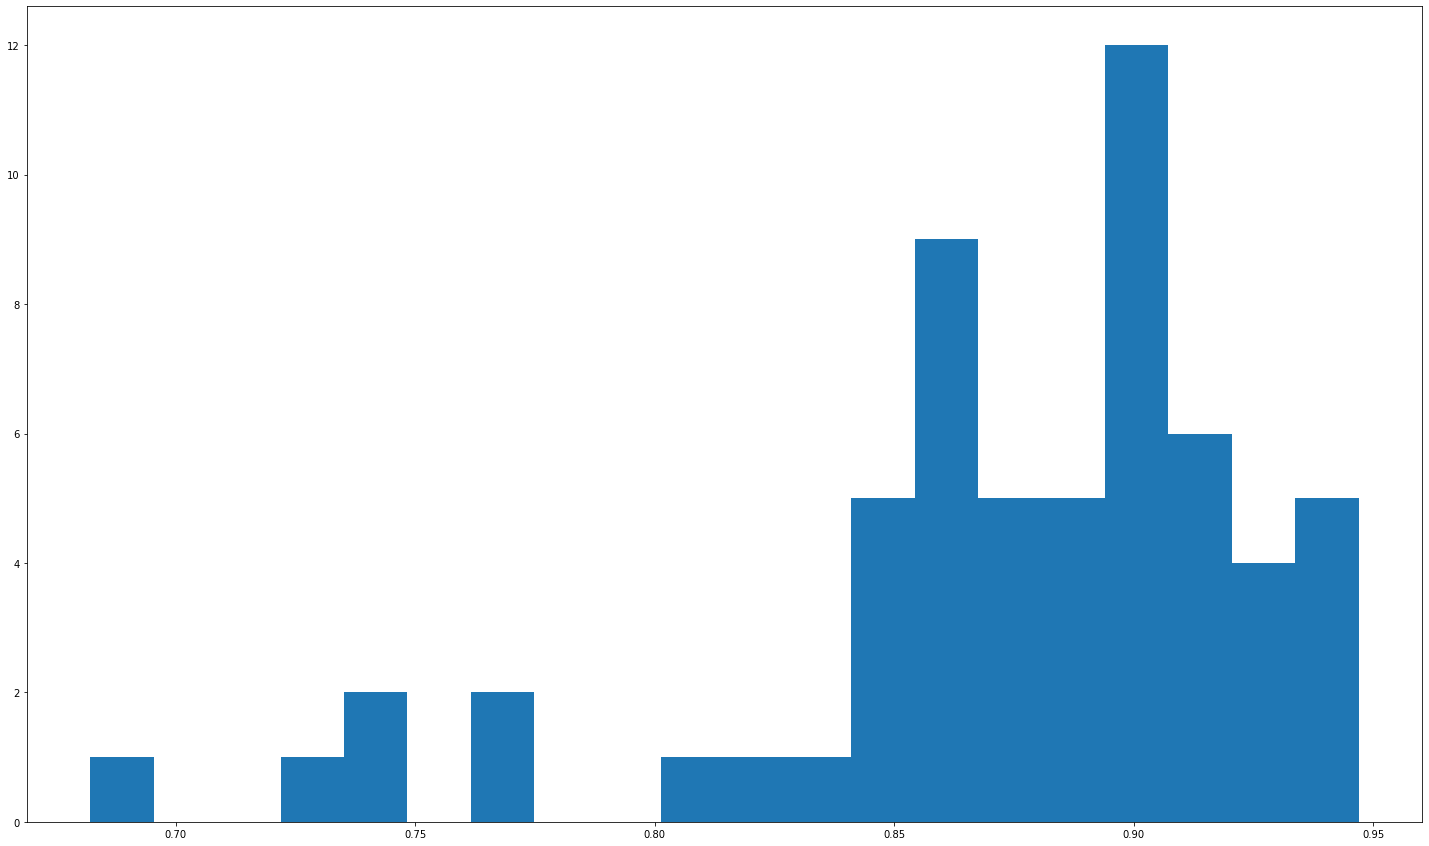

In [7]:
plt.hist(dice_df.dice_score, bins = 20);

In [8]:
dice_df.dice_score.describe()

count    60.000000
mean      0.873023
std       0.055668
min       0.682197
25%       0.856765
50%       0.883270
75%       0.906439
max       0.946937
Name: dice_score, dtype: float64

In [9]:
dice_df

,patientID,dice_score,volume
16,VS91,0.682197,5766.861
14,VS234,0.730769,56.52466
54,VS283,0.736842,32.299805
15,VS322,0.746544,253.68805
51,VS93,0.770227,123.81592
38,VS100,0.772414,128.5263
33,VS221,0.801362,312.23145
26,VS1,0.814815,429.99115
56,VS53,0.828051,506.7032
44,VS7,0.844888,1155.3909


## Best Predicion

In [16]:
subjectnumber='VS252'

In [17]:
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_99_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)

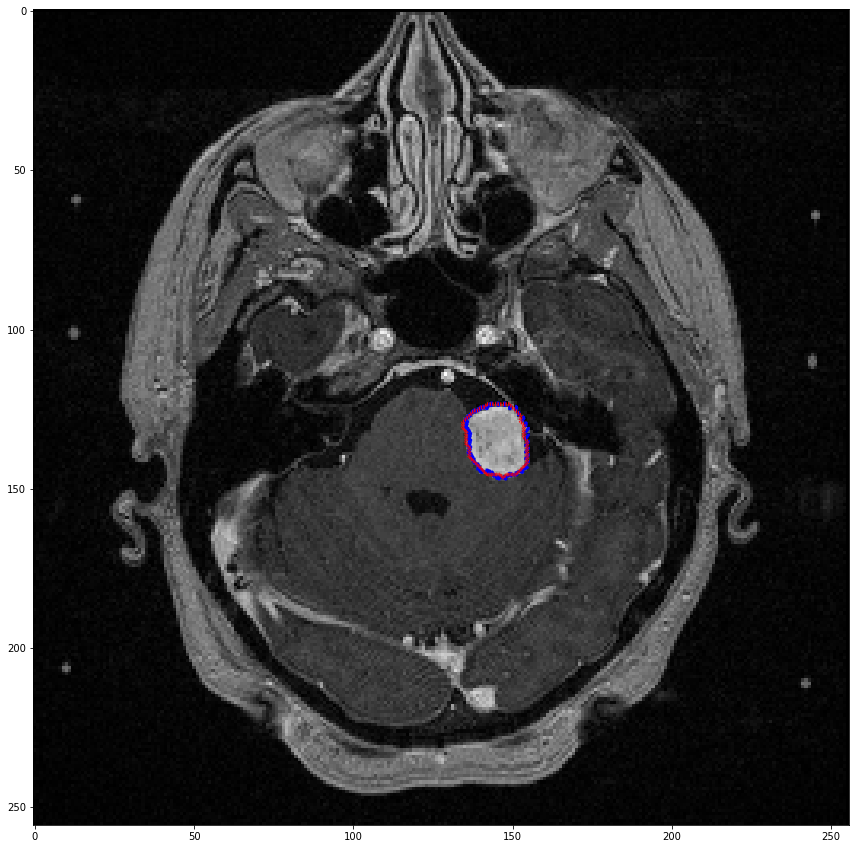

In [18]:
axslice=72
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=2.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=1,linestyles='dotted')
plt.show()

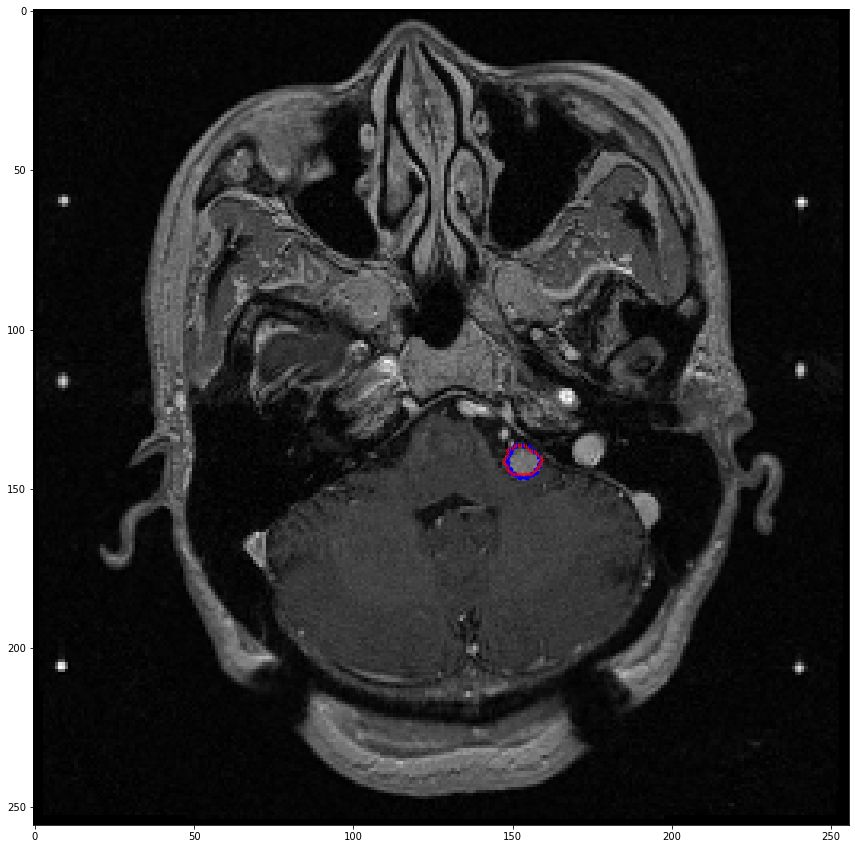

In [14]:
subjectnumber='VS130'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_99_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=70
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=2.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=1,linestyles='dotted')
plt.show()

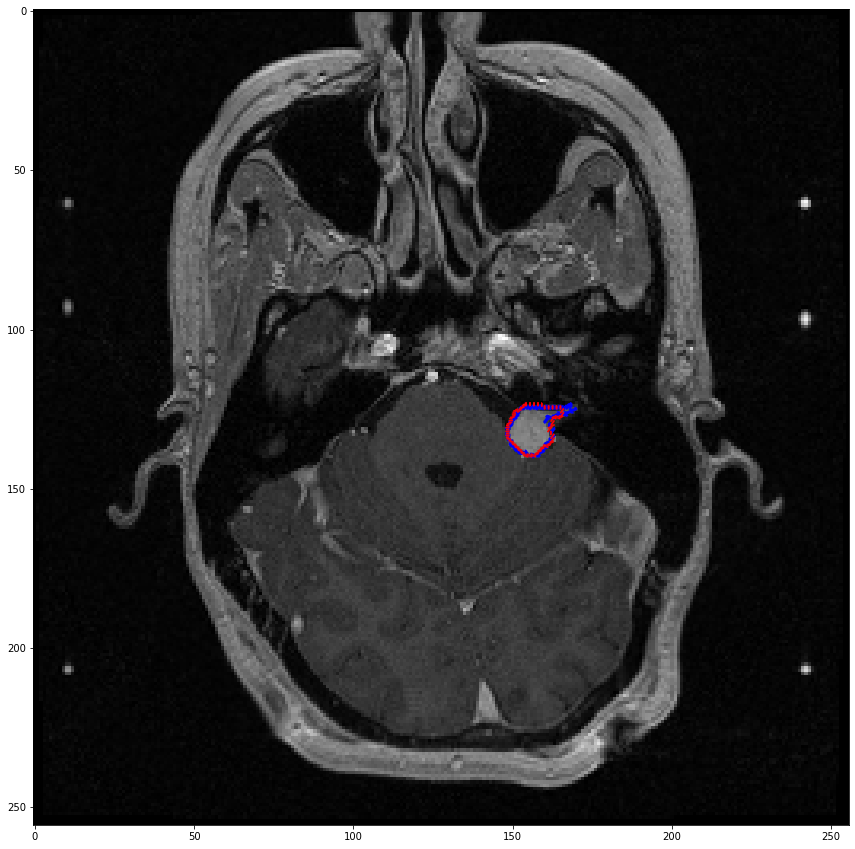

In [14]:
subjectnumber='VS148'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_99_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=72
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=2.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=1.5,linestyles='dotted')
plt.show()

## Worst Prediction

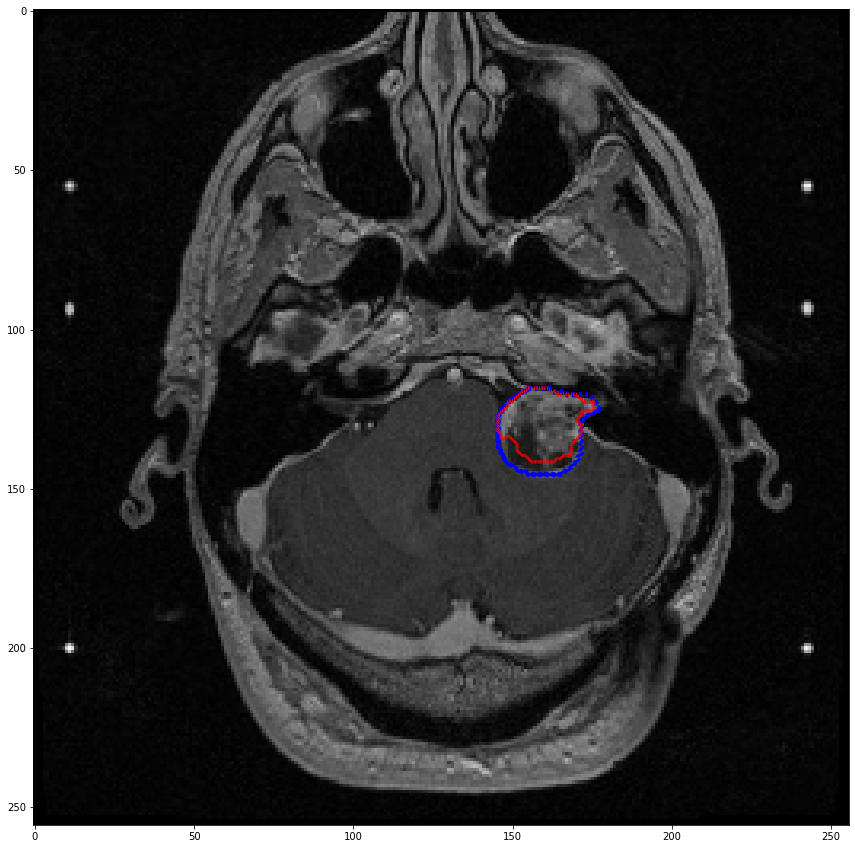

In [19]:
subjectnumber='VS91'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_99_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=66
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=2.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=1,linestyles='dotted')
plt.show()

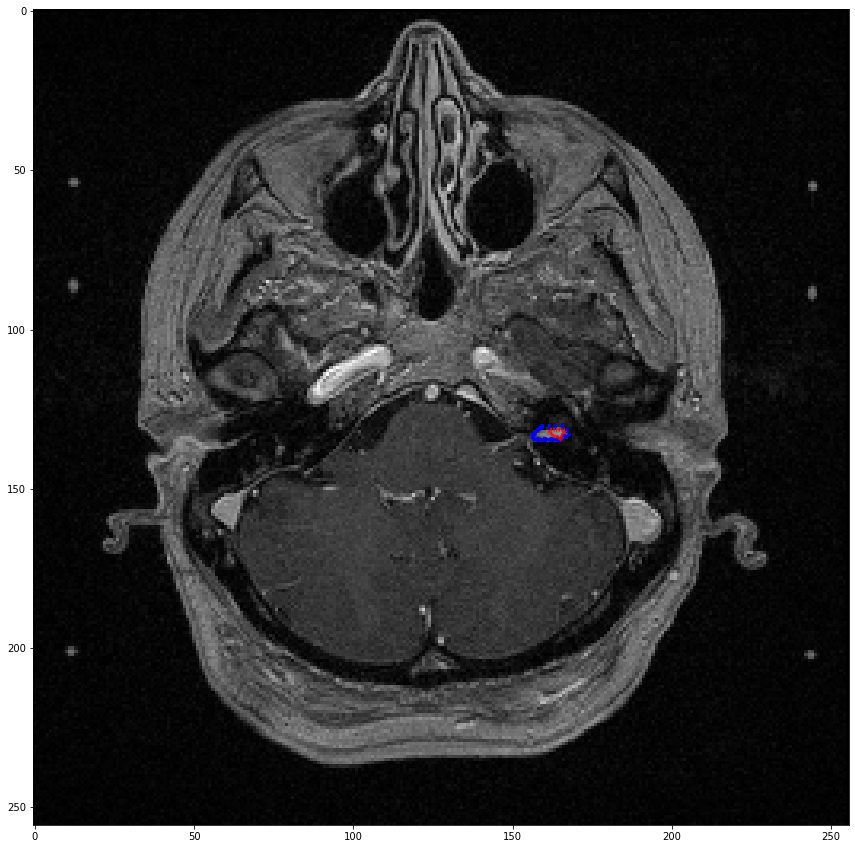

In [22]:
subjectnumber='VS322'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_99_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=60
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=2.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=1,linestyles='dotted')
plt.show()

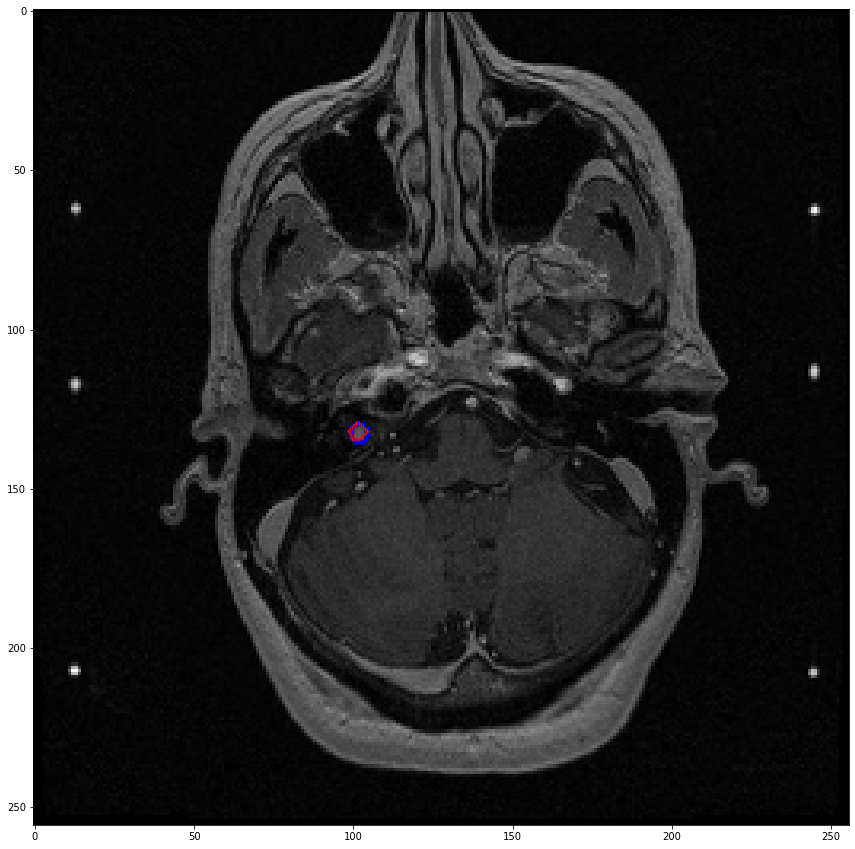

In [20]:
subjectnumber='VS234'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_99_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=60
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=2.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=1,linestyles='dotted')
plt.show()

In [19]:
def image_range(orientation,sample):
    #orientation can only be axslice,corslice,sagslice
    #data format VSpt['VSmask']
    checker = True
    if orientation == 'axslice':
        for i in range(sample.shape[3]):
            if sample.data[0,:,:,i].sum() != 0:
                if checker:
                    start = i
                checker = False
            if (sample.data[0,:,:,i].sum() == 0) and (not checker) and (i > start) :
                end = i-1
                break
        return start,end  
    if orientation == 'corslice':
        for i in range(sample.shape[2]):
            if sample.data[0,:,i,:].sum() != 0:
                if checker:
                    start = i
                checker = False
            if (sample.data[0,:,i,:].sum() == 0) and (not checker) and (i > start) :
                end = i-1
                break
        return start,end  
    if orientation == 'sagslice':
        for i in range(sample.shape[1]):
            if sample.data[0,i,:,:].sum() != 0:
                if checker:
                    start = i
                checker = False
            if (sample.data[0,i,:,:].sum() == 0) and (not checker) and (i > start) :
                end = i-1
                break
        return start,end  
image_range('axslice',VSpt['VSmask_truth'])

(75, 80)

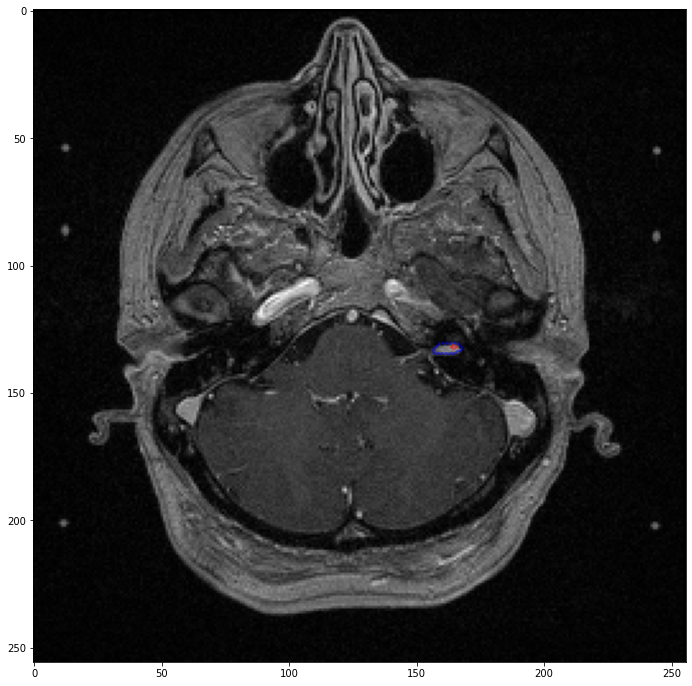

In [30]:
subjectnumber='VS322'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_130_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=60
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=0.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=0.5,linestyles='dotted')
plt.show()

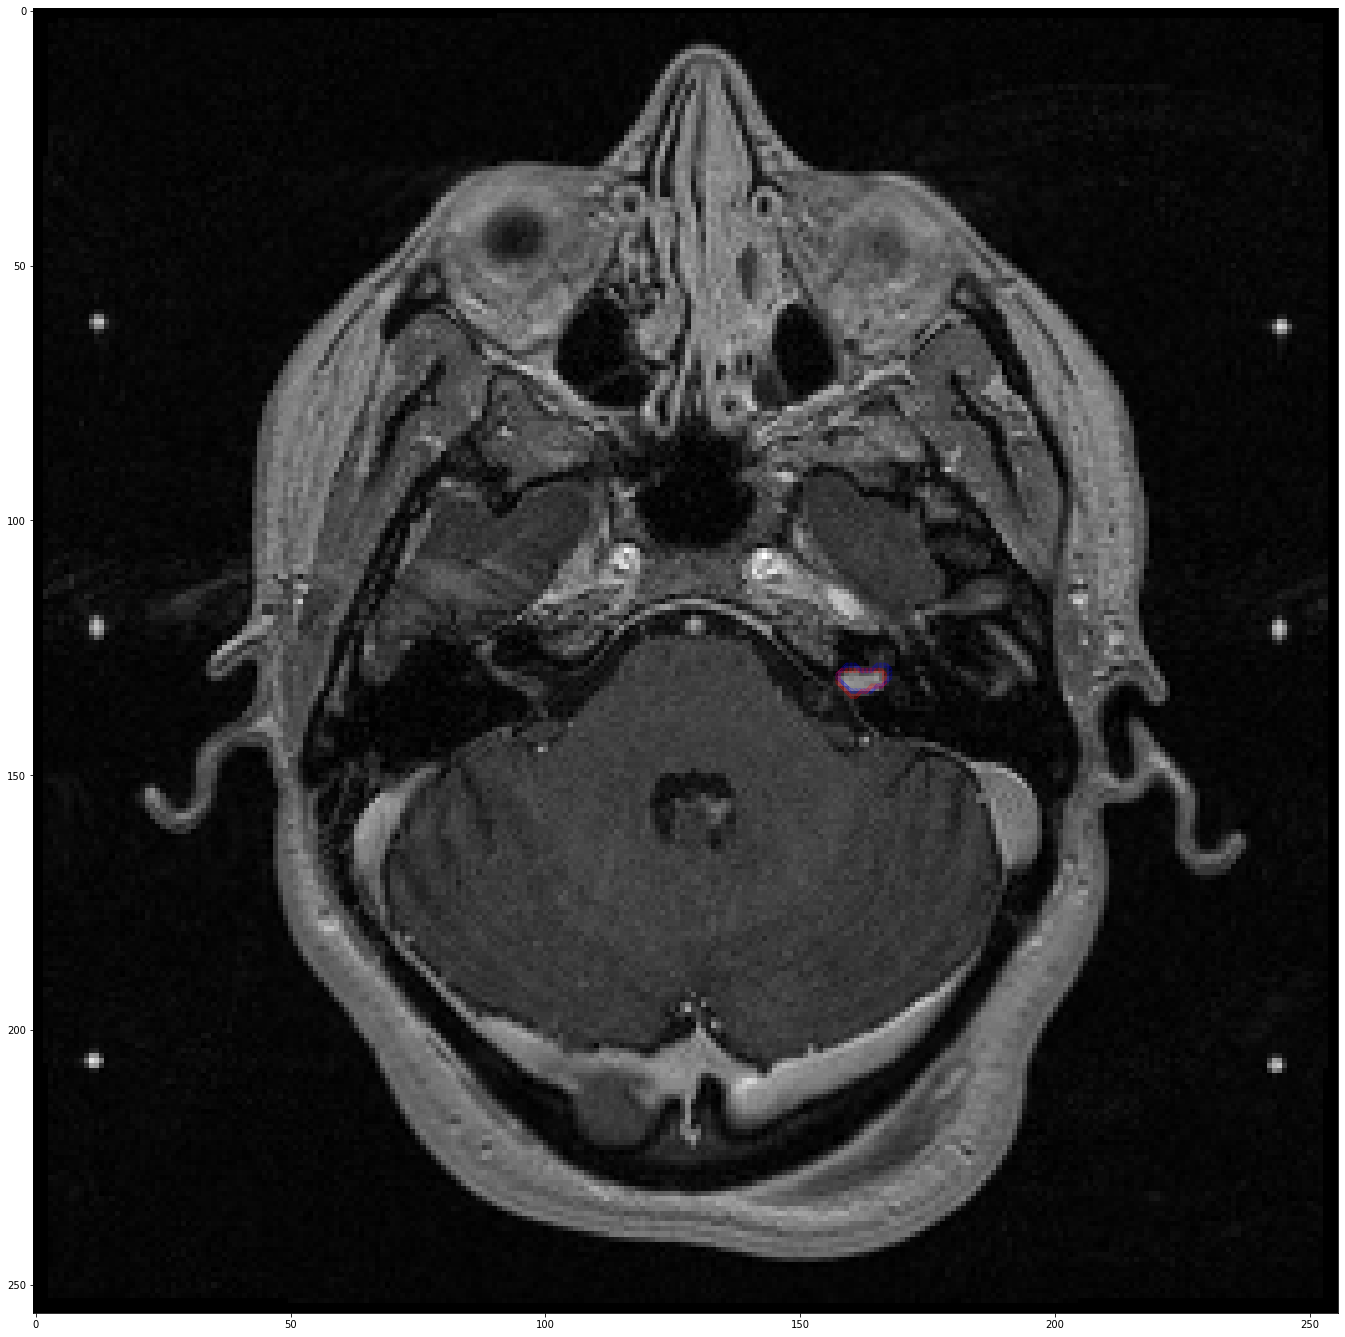

In [32]:
subjectnumber='VS93'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_test_130_epochs/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=76
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=0.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=0.5,linestyles='dotted')
plt.show()

## Model with validation

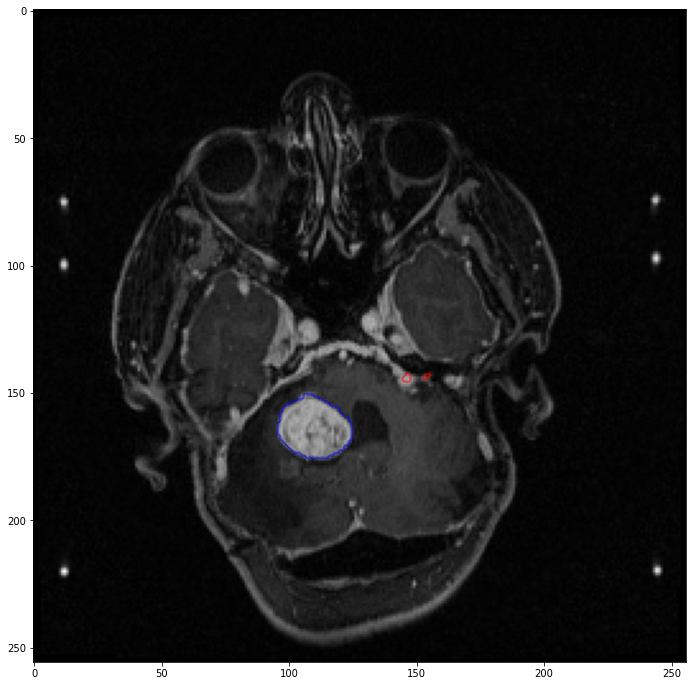

In [28]:
subjectnumber='VS118'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_val/VS_Validation_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=75
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=0.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=0.5,linestyles='dotted')
plt.show()

/gpfs/share/apps/python/gpu/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


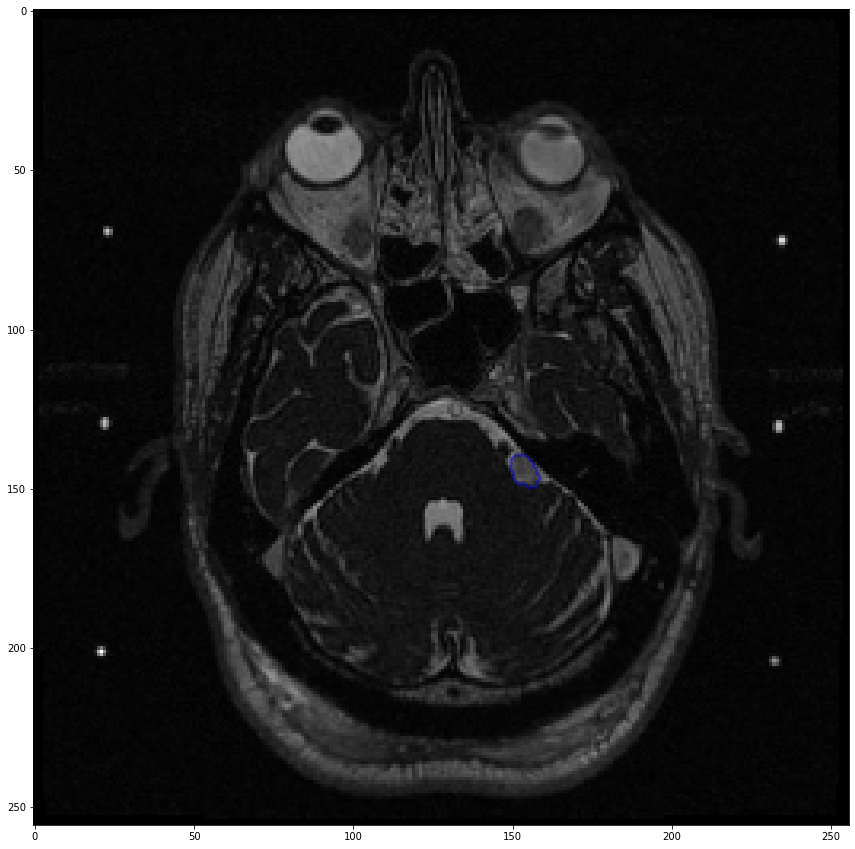

In [14]:
subjectnumber='VS149'
VSpt=tio.Subject(
    mri=tio.LabelMap(sorted(Path('./data_processed_CISS/'+subjectnumber).glob('*image*'))[0]),
    VSmask_truth=tio.LabelMap(sorted(Path('./data_processed_CISS/'+subjectnumber).glob('*mask_VS*'))[0]),
    VSmask_pred=tio.LabelMap(Path('./predictions_ciss/VS_VALIDATION_'+subjectnumber[2:]+'.nii.gz')),
)
axslice=40
img1=plt.imshow(np.rot90(VSpt['mri']['data'][0,:,:,axslice],k=3),cmap='gray')
img2=plt.contour(np.rot90(VSpt['VSmask_truth']['data'][0,:,:,axslice],k=3),colors='blue',linewidths=0.5,linestyles='dotted')
img3=plt.contour(np.rot90(VSpt['VSmask_pred']['data'][0,:,:,axslice],k=3),colors='red',linewidths=0.5,linestyles='dotted')
plt.show()


In [13]:
VSpt['VSmask_truth']['data'].unique()

tensor([0, 1], dtype=torch.int16)